In [37]:
import io
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Dropout, Input
from sklearn.utils import resample

#for model
# Import Statements
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import transformers
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
#!pip install openpyxl

In [3]:
df =  pd.read_json('C:\\Users\\ivsvi\\Codes\\Codes in Main drive\Masters\\SEM-3\\DL\\Final Project\\Summarisation DataSet Creation\\Complete Summarized Dataset.json')

In [4]:
df = df.dropna() # To remove any None values
df.head()

,Judgement,Domain,Judgement Status,Court,Abstractive Summarized Judgements,Extractive Summarized Judgements
0,"""This was an appeal from a judgment and decree...",Civil,1,Supreme Court,In order to enforce war-time controls another ...,"According to the Respondent, on the 11th Augus..."
1,"""This was an application under article 32 (1) ...",Civil,2,Supreme Court,The second part of this bye-law clearly contem...,"to the petitioner. ""You are hereby informed th..."
2,"""APPEAL from a judgment of the High Court of H...",Civil,0,Supreme Court,The learned advocate for the appellant contend...,749 The sole point for determination in the ap...
3,"""APPEAL under article 374(4) of the Constituti...",Civil,0,Supreme Court,It has been held that the first appellate cour...,"On receipt of the letter in the civil court, t..."
4,"""Petitions under Art. 136 of the Constitution ...",Criminal,3,Supreme Court,It was pointed out that in respect of convicti...,Under article 374 (4) on and from the com- men...


In [5]:
print(df['Judgement Status'].value_counts())

Judgement Status
1    175
2    143
0    143
3    132
Name: count, dtype: int64


In [6]:
# Separate majority class (class 1) and minority classes (classes 0, 2, and 3)
df_majority = df[df['Judgement Status'] == 1]
df_minority_0 = df[df['Judgement Status'] == 0]
df_minority_2 = df[df['Judgement Status'] == 2] 
df_minority_3 = df[df['Judgement Status'] == 3]

In [7]:
# Calculate the number of samples in the majority class (class 1)
majority_class_size = df_majority.shape[0]

In [8]:
df_majority.shape

(175, 6)

In [9]:
majority_class_size

175

In [10]:
# Randomly sample from the minority classes to match the majority class size
df_minority_0_sampled = resample(df_minority_0, 
                                  replace=True,       # Sample with replacement
                                  n_samples=majority_class_size,  # Match majority class size
                                  random_state=123)   # Set random seed for reproducibility

In [11]:
df_minority_2_sampled = resample(df_minority_2, 
                                  replace=True, 
                                  n_samples=majority_class_size,    
                                  random_state=123)

In [12]:
df_minority_3_sampled = resample(df_minority_3, 
                                  replace=True, 
                                  n_samples=majority_class_size,    
                                  random_state=123)

In [13]:
# Combine the majority class with the resampled minority classes
df_balanced = pd.concat([df_majority, df_minority_0_sampled, df_minority_2_sampled, df_minority_3_sampled])

In [14]:
# Verify the new class distribution
print(df_balanced['Judgement Status'].value_counts())

Judgement Status
1    175
0    175
2    175
3    175
Name: count, dtype: int64


In [15]:
df = df_balanced

In [16]:
# Verify the new class distribution
print(df['Judgement Status'].value_counts())

Judgement Status
1    175
0    175
2    175
3    175
Name: count, dtype: int64


## Splitting the data for complete, extractive and abstractive summarized texts

In [17]:
# Abstractive Data
df_abstractive_sentences = df[['Abstractive Summarized Judgements','Judgement Status']]

In [18]:
from sklearn.model_selection import train_test_split

# Train and Test Split for Abstractive Data
df_train_abstractive_sentences, df_test_abstractive_sentences = train_test_split(df_abstractive_sentences, test_size=0.20, random_state=42)

## Converting the Judgement Status to Categorical Values

In [19]:
from tensorflow.keras.utils import to_categorical

# Abstractive Data
y_train_abstractive = to_categorical(df_train_abstractive_sentences['Judgement Status'])
y_test_abstractive = to_categorical(df_test_abstractive_sentences['Judgement Status'])

## Building Model

In [20]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [21]:
def tokenize_BERT(df_column, max_length, tokenizer):
    tokenized_output = tokenizer(
        text=df_column.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    return tokenized_output

In [22]:
x_train_abstractive_bert = tokenize_BERT(df_train_abstractive_sentences['Abstractive Summarized Judgements'], max_length=200, tokenizer=bert_tokenizer)
x_test_abstractive_bert = tokenize_BERT(df_test_abstractive_sentences['Abstractive Summarized Judgements'], max_length=200, tokenizer=bert_tokenizer)

In [23]:
input_ids_abstractive_bert = x_train_abstractive_bert['input_ids']
attention_mask_abstractive_bert = x_train_abstractive_bert['attention_mask']

In [24]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Input
max_len = 200

input_ids_abstractive_bert = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask_abstractive_bert = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# BERT embeddings
embeddings = bert_model(input_ids_abstractive_bert, attention_mask=input_mask_abstractive_bert)[0]
out = GlobalMaxPool1D()(embeddings)

# Add L2 regularization to Dense layers
regularization_strength = 0.01  # You can change this value as per your needs

# Layer-1 with L2 regularization
#out = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(regularization_strength))(out)
#out = Dropout(0.2)(out)

# Layer-2 with L2 regularization
out = Dense(512, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
out = Dropout(0.2)(out)

out = Dense(256, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
out = Dropout(0.2)(out)

# Layer-3 with L2 regularization
out = Dense(128, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
# Dropout layer
out = Dropout(0.2)(out)


# Layer-4 with L2 regularization
out = Dense(32, activation='relu', 
            kernel_regularizer=regularizers.l2(regularization_strength))(out)
out = Dropout(0.2)(out)
# Output layer
y = Dense(4, activation='sigmoid')(out)

# Create the model
model_abstractive_bert = tf.keras.Model(inputs=[input_ids_abstractive_bert, input_mask_abstractive_bert], outputs=y)

# Set the third layer's weights to be trainable
model_abstractive_bert.layers[1].trainable = True  # Layer 1 (Dense layer after BERT embeddings)
model_abstractive_bert.layers[2].trainable = True

In [25]:
bert_optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
bert_loss = CategoricalCrossentropy(from_logits = True)
bert_metric = CategoricalAccuracy('balanced_accuracy')

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training after 3 epochs of no improvement
    restore_best_weights=True
)

reduce_lrearning_rate = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Minimum learning rate
)

# Compile the model
model_abstractive_bert.compile(
    optimizer = bert_optimizer,
    loss=bert_loss,
    metrics = bert_metric)
model_abstractive_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                           

In [26]:
history_data_abstractive = model_abstractive_bert.fit(
    x ={'input_ids':x_train_abstractive_bert['input_ids'],'attention_mask':x_train_abstractive_bert['attention_mask']} ,
    y = y_train_abstractive,
    validation_data = (
    {'input_ids':x_test_abstractive_bert['input_ids'],'attention_mask':x_test_abstractive_bert['attention_mask']}, y_test_abstractive
    ),
    epochs=30,  # Maximum number of epochs
    batch_size=10,  # Adjust this based on your resources
    callbacks=[early_stopping, reduce_lrearning_rate],  # Add callbacks here
    verbose=1
)

Epoch 1/30


c:\Users\ivsvi\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 22s 230ms/step - loss: 13.0470 - balanced_accuracy: 0.2232 - val_loss: 12.6793 - val_balanced_accuracy: 0.2000 - lr: 5.0000e-05
Epoch 2/30
56/56 [==============================] - 12s 208ms/step - loss: 12.5347 - balanced_accuracy: 0.2554 - val_loss: 12.3526 - val_balanced_accuracy: 0.2071 - lr: 5.0000e-05
Epoch 3/30
56/56 [==============================] - 12s 206ms/step - loss: 12.2332 - balanced_accuracy: 0.2304 - val_loss: 12.0923 - val_balanced_accuracy: 0.2286 - lr: 5.0000e-05
Epoch 4/30
56/56 [==============================] - 12s 208ms/step - loss: 12.0028 - balanced_accuracy: 0.2750 - val_loss: 11.8620 - val_balanced_accuracy: 0.3286 - lr: 5.0000e-05
Epoch 5/30
56/56 [==============================] - 11s 205ms/step - loss: 11.7951 - balanced_accuracy: 0.3125 - val_loss: 11.6897 - val_balanced_accuracy: 0.3786 - lr: 5.0000e-05
Epoch 6/30
56/56 [==============================] - 11s 202ms/step - loss: 11.5832 - balanced_accuracy: 0.3893 

In [27]:
predicted_raw_abstractive_bert = model_abstractive_bert.predict({'input_ids':x_test_abstractive_bert['input_ids'],'attention_mask':x_test_abstractive_bert['attention_mask']})
predicted_raw_abstractive_bert[0]

5/5 [==============================] - 3s 183ms/step


array([0.13162147, 0.84374595, 0.05388127, 0.12824896], dtype=float32)

In [28]:
import numpy as np

y_predicted_abstractive_bert = np.argmax(predicted_raw_abstractive_bert, axis = 1)
y_true_abstractive_bert = df_test_abstractive_sentences['Judgement Status']

In [29]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true_abstractive_bert, y_predicted_abstractive_bert))

print("F1 Score: ",f1_score(y_true_abstractive_bert,y_predicted_abstractive_bert, average='macro'))

              precision    recall  f1-score   support

           0       0.83      0.53      0.64        36
           1       0.60      0.79      0.68        43
           2       0.86      0.86      0.86        29
           3       0.81      0.78      0.79        32

    accuracy                           0.74       140
   macro avg       0.77      0.74      0.74       140
weighted avg       0.76      0.74      0.73       140

F1 Score:  0.7449468889445511


In [30]:
x_train_abstractive_bert = {'input_ids':x_train_abstractive_bert['input_ids'],'attention_mask':x_train_abstractive_bert['attention_mask']}

train_loss_abstractive_bert, train_accuracy_abstractive_bert = model_abstractive_bert.evaluate(x_train_abstractive_bert, y_train_abstractive, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy_abstractive_bert))

c:\Users\ivsvi\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Training Accuracy: 0.9875


In [31]:
x_test_abstractive_bert = {'input_ids':x_test_abstractive_bert['input_ids'],'attention_mask':x_test_abstractive_bert['attention_mask']}

test_loss_abstractive_bert, test_accuracy_abstractive_bert = model_abstractive_bert.evaluate(x_test_abstractive_bert, y_test_abstractive, verbose=False)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_abstractive_bert))

Testing Accuracy:  0.7357


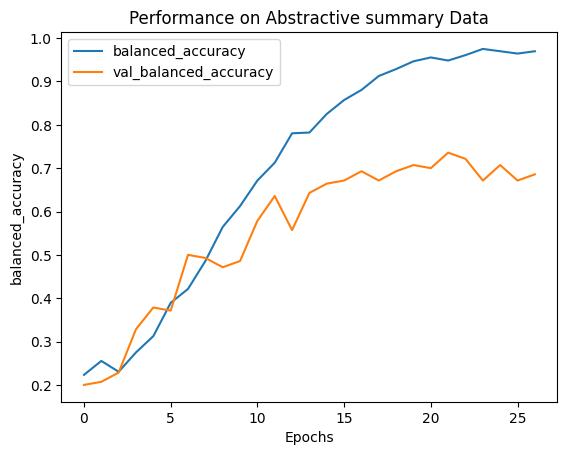

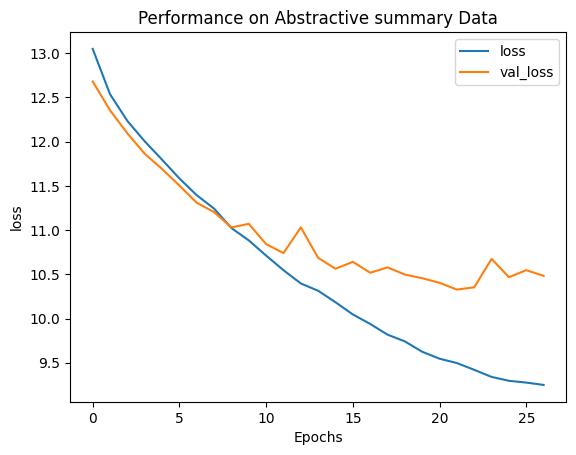

In [38]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title("Performance on Abstractive summary Data")
    plt.show()
    
plot_graphs(history_data_abstractive, "balanced_accuracy")
plot_graphs(history_data_abstractive, "loss")

# Stop HERE

In [ ]:
model_abstractive_bert.save("C:/Users/ivsvi/Codes/Codes in Main drive/Masters/SEM-3/DL/Final Project/Saved Models/ABS-BERT.h5")